In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import numpy as np
import cv2

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator, load_img 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Conv2D,MaxPooling2D,Dropout,BatchNormalization
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D

2022-07-05 08:53:51.562840: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/dparanou/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-07-05 08:53:51.563051: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Explore the data

In [2]:
for dirname, _, filenames in os.walk('archive/chest_xray/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break

archive/chest_xray/train/PNEUMONIA/person1256_bacteria_3214.jpeg
archive/chest_xray/train/NORMAL/IM-0601-0001.jpeg
archive/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg
archive/chest_xray/val/NORMAL/NORMAL2-IM-1437-0001.jpeg
archive/chest_xray/chest_xray/.DS_Store
archive/chest_xray/chest_xray/train/.DS_Store
archive/chest_xray/chest_xray/train/PNEUMONIA/person1256_bacteria_3214.jpeg
archive/chest_xray/chest_xray/train/NORMAL/IM-0601-0001.jpeg
archive/chest_xray/chest_xray/val/.DS_Store
archive/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg
archive/chest_xray/chest_xray/val/NORMAL/NORMAL2-IM-1437-0001.jpeg
archive/chest_xray/chest_xray/test/.DS_Store
archive/chest_xray/chest_xray/test/PNEUMONIA/person90_bacteria_443.jpeg
archive/chest_xray/chest_xray/test/NORMAL/NORMAL2-IM-0294-0001.jpeg
archive/chest_xray/test/PNEUMONIA/person90_bacteria_443.jpeg
archive/chest_xray/test/NORMAL/NORMAL2-IM-0294-0001.jpeg
archive/chest_xray/__MACOSX/._chest_xray
archive/chest_

In [2]:
train_directory = 'archive/chest_xray/train/'
test_directory = 'archive/chest_xray/test/'
val_directory = 'archive/chest_xray/val/'

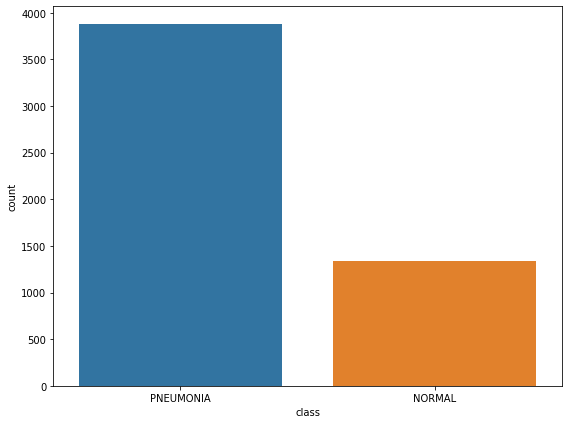

In [3]:
# count number of images in each class for training data
df = pd.DataFrame(columns=['class','count'])
df['class'] = pd.Series([os.listdir(train_directory)[x] for x in range(0,2)])
df['count'] = pd.Series([len(os.listdir(os.path.join(train_directory,os.listdir(train_directory)[x]))) for x in range(0,2)])
plt.figure(figsize=(8,6))
g = sns.barplot(x='class', y='count',data=df)
g.set_xticklabels(g.get_xticklabels(), rotation=0)
plt.tight_layout()

The data is imbalanced as only 1/4 of the images are in Normal class and the rest is Pneumonia.
So we will augmaunt our data.

In [7]:
# rescale all images by 1./255.
train_gen = ImageDataGenerator(rescale=1./255, 
                                rotation_range=20 ,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                brightness_range=[0.6,0.9],
                                fill_mode='nearest') 
test_gen = ImageDataGenerator( rescale = 1.0/255)

# flow training images in batches of 32 using train_gen generator
train_data = train_gen.flow_from_directory(train_directory, target_size = (224, 224), batch_size = 32, class_mode = 'binary')

Found 5216 images belonging to 2 classes.


In [8]:
# get test data
test_data = test_gen.flow_from_directory(test_directory, target_size = (224, 224), batch_size = 32, class_mode = 'binary')

Found 624 images belonging to 2 classes.


In [9]:
# get validate data
val_data = test_gen.flow_from_directory(val_directory, target_size = (224, 224), batch_size = 32, class_mode = 'binary')

Found 16 images belonging to 2 classes.


In [8]:
# check the classes in the train dataset
train_data.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

### Visualize data

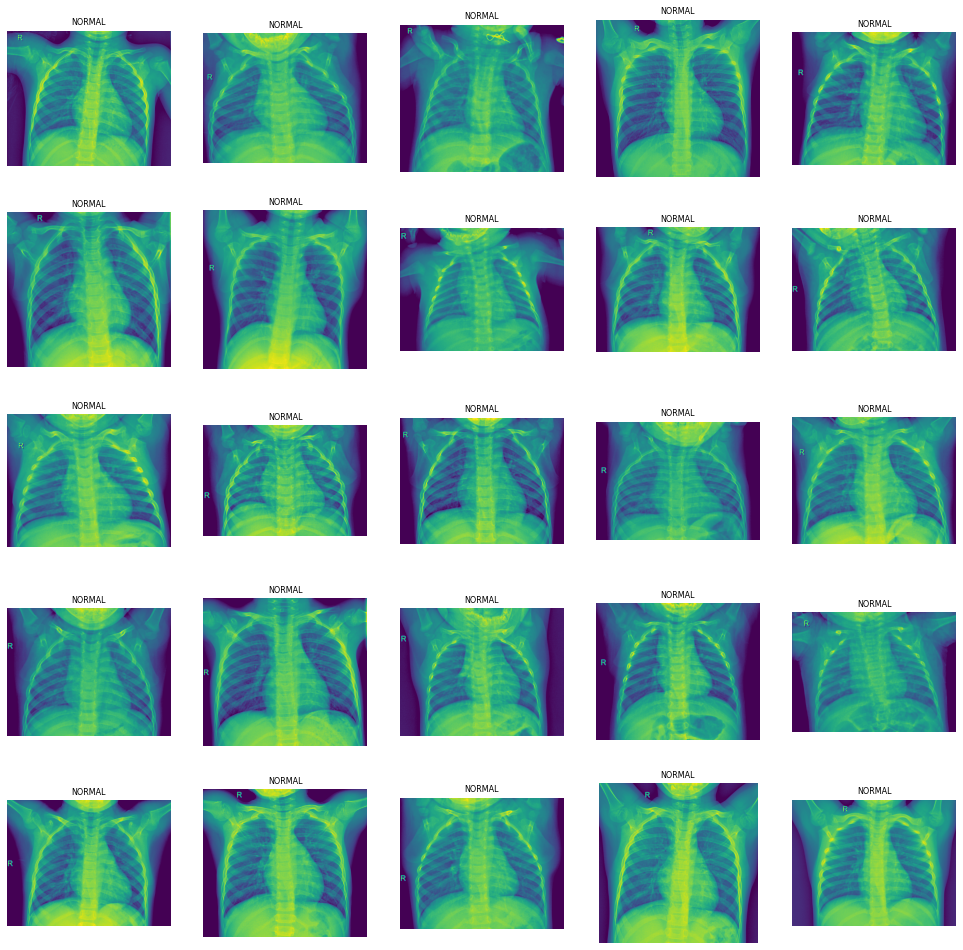

In [11]:
# Visualize some images from the train dataset that belongs to NORMAL class
fig, axes = plt.subplots(5, 5, figsize = (17,17))

axes = axes.ravel() # flaten the matrix into array
for i in np.arange(0, 5 * 5): 
    label ='NORMAL'
    class_dir = os.path.join(train_directory,label)
    # Select a random image
    image = random.choice(os.listdir(class_dir))
    # read and display an image with the selected index    
    img = plt.imread(os.path.join(class_dir,image))
    axes[i].imshow( img )
    axes[i].set_title(label, fontsize = 8) # the label
    axes[i].axis('off')

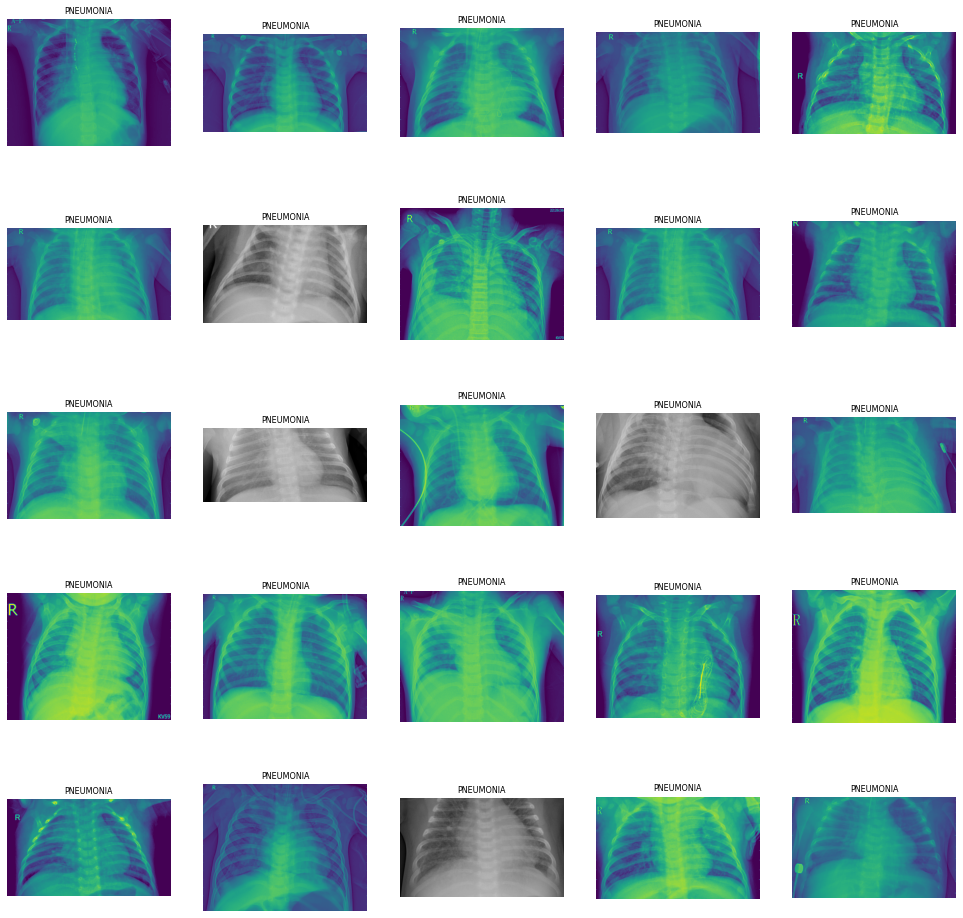

In [12]:
# Visualize some images from the train dataset that belongs to PNEUMONIA class
fig, axes = plt.subplots(5, 5, figsize = (17,17))

axes = axes.ravel() # flaten the matrix into array
for i in np.arange(0, 5 * 5): 
    label ='PNEUMONIA'
    class_dir = os.path.join(train_directory,label)
    # Select a random image
    image = random.choice(os.listdir(class_dir))
    # read and display an image with the selected index    
    img = plt.imread(os.path.join(class_dir,image))
    axes[i].imshow( img )
    axes[i].set_title(label, fontsize = 8) # the label
    axes[i].axis('off')

### Classic Machine Learning techniques

### Neural Network

In [8]:
import ssl 

try:
  _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
  pass
else:
  ssl._create_default_https_context = _create_unverified_https_context

#### Transfer Learning

In [11]:
# Model - Transfer Learning
Vgg = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
Vgg.trainable = False

model_tr_learning = tf.keras.models.Sequential()
model_tr_learning.add(Vgg)
model_tr_learning.add(tf.keras.layers.GlobalAveragePooling2D())
model_tr_learning.add(tf.keras.layers.Dense(512, activation='relu'))
model_tr_learning.add(tf.keras.layers.Dense(128, activation='relu'))
model_tr_learning.add(tf.keras.layers.Dropout(0.2))
model_tr_learning.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_tr_learning.summary()

2022-07-05 08:59:44.350620: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/dparanou/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-07-05 08:59:44.350658: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-05 08:59:44.350685: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (dparanou-inspiron-5559): /proc/driver/nvidia/version does not exist
2022-07-05 08:59:44.391361: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                        

In [12]:
opt = tf.keras.optimizers.Adam()
model_tr_learning.compile(loss='binary_crossentropy', metrics=['accuracy', 'binary_accuracy'], optimizer=opt)
history_tr_learning = model_tr_learning.fit(train_data, epochs = 10, validation_data = val_data, steps_per_epoch =163)

Epoch 1/10


2022-07-05 09:00:12.410869: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 411041792 exceeds 10% of free system memory.
2022-07-05 09:00:13.082679: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 411041792 exceeds 10% of free system memory.
2022-07-05 09:00:14.599060: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 205520896 exceeds 10% of free system memory.
2022-07-05 09:00:15.284141: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 205520896 exceeds 10% of free system memory.


  1/163 [..............................] - ETA: 35:29 - loss: 0.6757 - accuracy: 0.6562 - binary_accuracy: 0.6562

2022-07-05 09:00:22.494224: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 411041792 exceeds 10% of free system memory.


163/163 [==============================] - 1587s 10s/step - loss: 0.3262 - accuracy: 0.8549 - binary_accuracy: 0.8549 - val_loss: 0.3715 - val_accuracy: 0.8125 - val_binary_accuracy: 0.8125
Epoch 2/10
163/163 [==============================] - 1610s 10s/step - loss: 0.2115 - accuracy: 0.9130 - binary_accuracy: 0.9130 - val_loss: 0.3134 - val_accuracy: 0.8125 - val_binary_accuracy: 0.8125
Epoch 3/10
163/163 [==============================] - 1559s 10s/step - loss: 0.2027 - accuracy: 0.9166 - binary_accuracy: 0.9166 - val_loss: 0.5975 - val_accuracy: 0.7500 - val_binary_accuracy: 0.7500
Epoch 4/10
163/163 [==============================] - 1554s 10s/step - loss: 0.1753 - accuracy: 0.9321 - binary_accuracy: 0.9321 - val_loss: 0.4615 - val_accuracy: 0.8125 - val_binary_accuracy: 0.8125
Epoch 5/10
163/163 [==============================] - 1547s 9s/step - loss: 0.1732 - accuracy: 0.9327 - binary_accuracy: 0.9327 - val_loss: 0.3844 - val_accuracy: 0.8125 - val_binary_accuracy: 0.8125
Epoch 6

#### Evaluation of transfer learning model

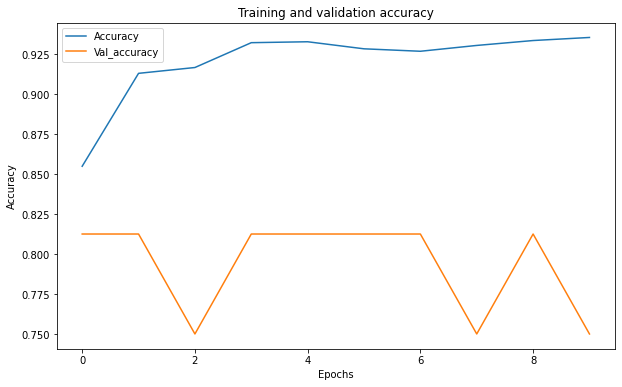

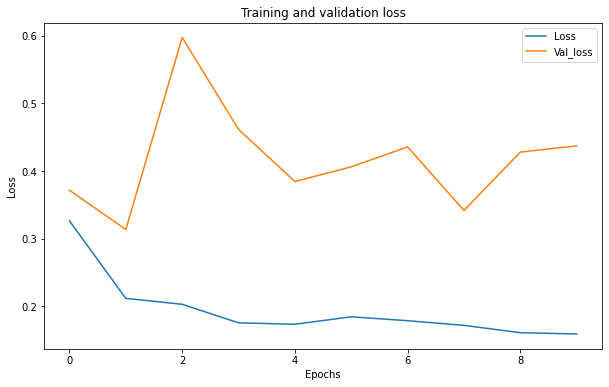

In [17]:
acc = history_tr_learning.history['accuracy']
val_acc  = history_tr_learning.history['val_accuracy']
loss     = history_tr_learning.history['loss']
val_loss = history_tr_learning.history['val_loss']

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.figure(figsize=(10,6))
plt.plot(epochs,acc)
plt.plot(epochs,val_acc)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title('Training and validation accuracy')
plt.legend(['Accuracy', 'Val_accuracy'])
#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.figure(figsize=(10,6))
plt.plot(epochs,loss)
plt.plot(epochs,val_loss)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Training and validation loss')
plt.legend(['Loss', 'Val_loss'])

1/1 [==============================] - 4s 4s/step - loss: 0.4371 - accuracy: 0.7500 - binary_accuracy: 0.7500
Confusion Matrix
[[5 3]
 [1 7]]
Classification Report
              precision    recall  f1-score   support

   PNEUMONIA       0.83      0.62      0.71         8
      NORMAL       0.70      0.88      0.78         8

    accuracy                           0.75        16
   macro avg       0.77      0.75      0.75        16
weighted avg       0.77      0.75      0.75        16



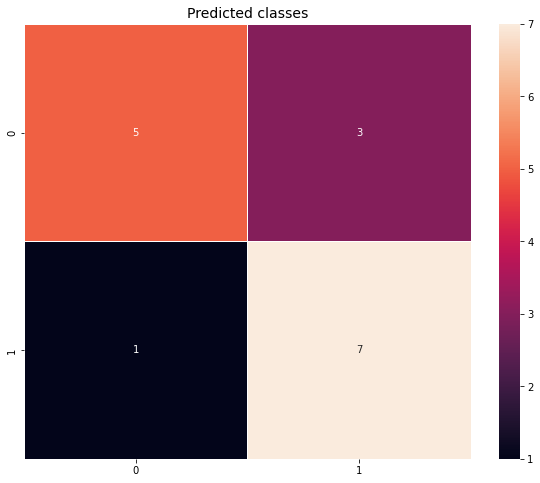

In [14]:
from sklearn.metrics import confusion_matrix, classification_report

# Confusion Matrix and Classification Report of Test dataset
Y_pred = model_tr_learning.predict(val_data)
model_tr_learning.evaluate(val_data)
y_pred= np.where(Y_pred > 0.5, 1, 0)

print('Confusion Matrix')
print(confusion_matrix(val_data.classes, y_pred))

print('Classification Report')
target_names = os.listdir(train_directory)
print(classification_report(val_data.classes, y_pred, target_names=target_names))
plt.figure(figsize=(10,8))

plt.title('Predicted classes', size=14)
sns.heatmap(confusion_matrix(val_data.classes, y_pred), annot=True, fmt = '.0f',linewidths=.5)
plt.show()

#### CNN

In [18]:
# create model
regularizer = tf.keras.regularizers.L1L2(l1=0.01, l2=0.01)

model_cnn = Sequential()
model_cnn.add(Conv2D(8, (3, 3), activation="relu", input_shape=(224, 224, 3)))
model_cnn.add(MaxPooling2D(pool_size = (2, 2)))
model_cnn.add(Conv2D(16, (3, 3), activation="relu"))
model_cnn.add(MaxPooling2D(pool_size = (2, 2)))
model_cnn.add(Conv2D(32, (3, 3), activation="relu"))
model_cnn.add(MaxPooling2D(pool_size = (2, 2)))
model_cnn.add(Conv2D(64, (3, 3), activation="relu"))
model_cnn.add(MaxPooling2D(pool_size = (2, 2)))
model_cnn.add(Flatten())
model_cnn.add(Dropout(0.2))
model_cnn.add(Dense(16, activation='relu', kernel_regularizer=regularizer))
model_cnn.add(Dense(1, activation = 'sigmoid'))

model_cnn.summary()

model_cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
# fit the model
history_cnn = model_cnn.fit(train_data, validation_data=val_data, epochs=10, batch_size=200, verbose=2)
# evaluate the model
scores = model_cnn.evaluate(test_data, verbose=0)
print(f"Loss: {scores[0]}")
print(f"Accuracy: {scores[1] * 100}")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 32)      

#### Evaluation of CNN model

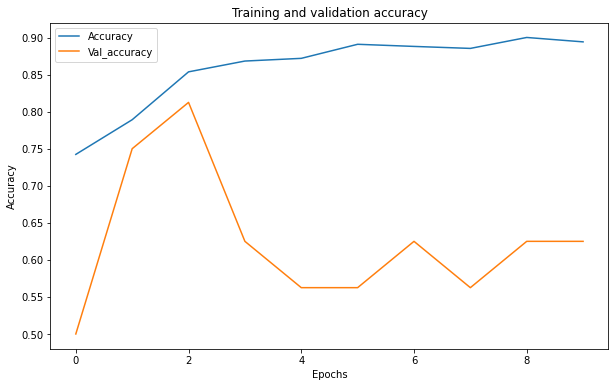

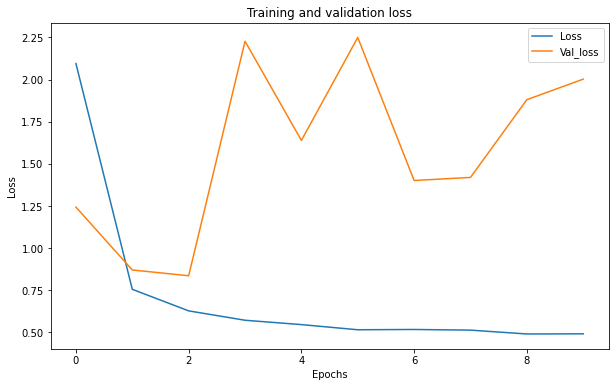

In [22]:
history_frame_cnn = pd.DataFrame(history_cnn.history)
plt.figure(figsize=(10,6))
plt.plot(history_frame_cnn.loc[:, ['accuracy']])
plt.plot(history_frame_cnn.loc[:, ['val_accuracy']])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title('Training and validation accuracy')
plt.legend(['Accuracy', 'Val_accuracy'])
#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.figure(figsize=(10,6))
plt.plot(history_frame_cnn.loc[:, ['loss']])
plt.plot(history_frame_cnn.loc[:, ['val_loss']])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Training and validation loss')
plt.legend(['Loss', 'Val_loss'])

1/1 [==============================] - 0s 423ms/step - loss: 2.0022 - accuracy: 0.6250
Confusion Matrix
[[2 6]
 [0 8]]
Classification Report
              precision    recall  f1-score   support

   PNEUMONIA       1.00      0.25      0.40         8
      NORMAL       0.57      1.00      0.73         8

    accuracy                           0.62        16
   macro avg       0.79      0.62      0.56        16
weighted avg       0.79      0.62      0.56        16



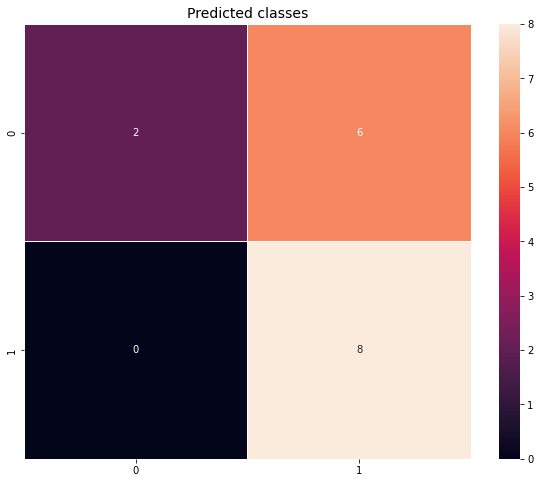

In [28]:
Y_pred_cnn = model_cnn.predict(val_data)
model_cnn.evaluate(val_data)
y_pred_cnn = np.where(Y_pred_cnn > 0.5, 1, 0)

print('Confusion Matrix')
print(confusion_matrix(val_data.classes, y_pred_cnn))

print('Classification Report')
target_names = os.listdir(train_directory)
print(classification_report(val_data.classes, y_pred_cnn, target_names=target_names))
plt.figure(figsize=(10,8))

plt.title('Predicted classes', size=14)
sns.heatmap(confusion_matrix(val_data.classes, y_pred_cnn), annot=True, fmt = '.0f',linewidths=.5)
plt.show()

#### CNN - 2

In [25]:
# create model
model_cnn2 = Sequential()
model_cnn2.add(Conv2D(32, (3, 3), activation="relu", input_shape=(224, 224, 3)))
model_cnn2.add(MaxPooling2D(pool_size = (2, 2)))
model_cnn2.add(Conv2D(32, (3, 3), activation="relu"))
model_cnn2.add(MaxPooling2D(pool_size = (2, 2)))
model_cnn2.add(Flatten())
model_cnn2.add(Dense(activation = 'relu', units = 128))
model_cnn2.add(Dense(activation = 'sigmoid', units = 1))

model_cnn2.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

model_cnn2.summary()
# fit the model
history_cnn2 = model_cnn2.fit(train_data, validation_data=val_data, epochs=10, batch_size=200, verbose=2)
# evaluate the model
scores = model_cnn2.evaluate(test_data, verbose=0)
print("Accuracy: {} \n Loss: {}".format(scores[1], scores[0]))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 93312)             0         
                                                                 
 dense_7 (Dense)             (None, 128)              

#### Evaluation of CNN model - 2

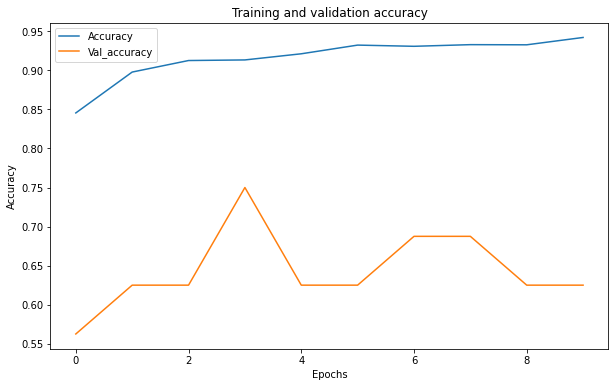

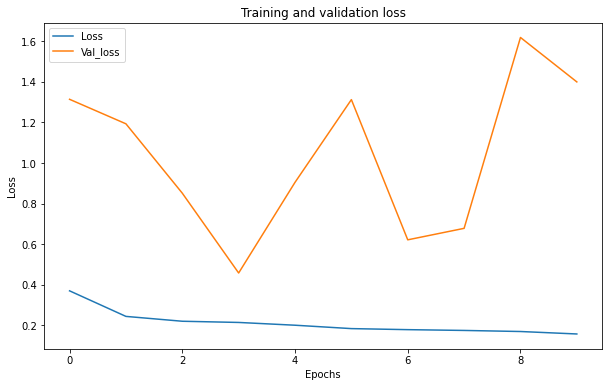

In [26]:
history_frame_cnn2 = pd.DataFrame(history_cnn2.history)
plt.figure(figsize=(10,6))
plt.plot(history_frame_cnn2.loc[:, ['accuracy']])
plt.plot(history_frame_cnn2.loc[:, ['val_accuracy']])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title('Training and validation accuracy')
plt.legend(['Accuracy', 'Val_accuracy'])
#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.figure(figsize=(10,6))
plt.plot(history_frame_cnn2.loc[:, ['loss']])
plt.plot(history_frame_cnn2.loc[:, ['val_loss']])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Training and validation loss')
plt.legend(['Loss', 'Val_loss'])

1/1 [==============================] - 0s 425ms/step - loss: 1.3999 - accuracy: 0.6250
Confusion Matrix
[[0 8]
 [2 6]]
Classification Report
              precision    recall  f1-score   support

   PNEUMONIA       0.00      0.00      0.00         8
      NORMAL       0.43      0.75      0.55         8

    accuracy                           0.38        16
   macro avg       0.21      0.38      0.27        16
weighted avg       0.21      0.38      0.27        16



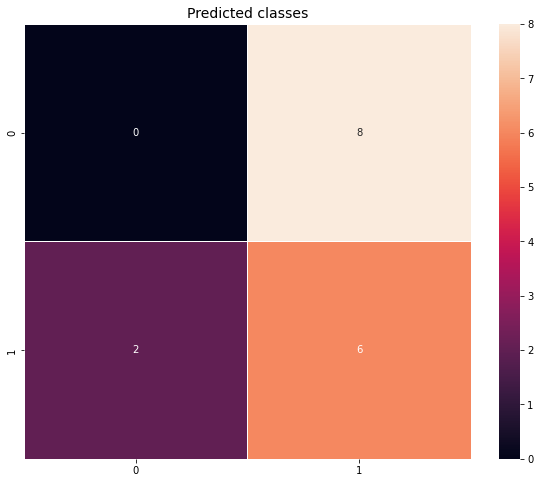

In [27]:
Y_pred_cnn2 = model_cnn2.predict(val_data)
model_cnn2.evaluate(val_data)
y_pred_cnn2 = np.where(Y_pred_cnn2 > 0.5, 1, 0)

print('Confusion Matrix')
print(confusion_matrix(val_data.classes, y_pred_cnn2))

print('Classification Report')
target_names = os.listdir(train_directory)
print(classification_report(val_data.classes, y_pred_cnn2, target_names=target_names))
plt.figure(figsize=(10,8))

plt.title('Predicted classes', size=14)
sns.heatmap(confusion_matrix(val_data.classes, y_pred_cnn2), annot=True, fmt = '.0f',linewidths=.5)
plt.show()